In [1]:
#@title Mount google drive

from google.colab import drive
drive.mount('/content/drive')

%cd './drive/MyDrive/gaze_estimation'

Mounted at /content/drive
/content/drive/MyDrive/gaze_estimation


In [2]:
#@title Import required modules

import os
import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression


from loss.likelihood_hetero import multivariate_nll_hetero_i, multivariate_njll_hetero_i
from hglm.covariance_module import covariance_module
from loss.h_likelihood_covariance import nhll_hetero_arbitrary
from util import make_reproducibility, TensorDataset, convert_to_xyz, mae, make_arbitrary_masking, k_fold_index
from networks import *
from hglm.hglm_hetero_arbitrary import hetero_covariance_without_val

In [3]:
#@title Load preprocessed & subsampled data (Within)

ids = np.load('../mpii_dataset/within_ids.npy')
images = torch.as_tensor(np.load('../mpii_dataset/within_images.npy'), dtype=torch.float)
hps = torch.as_tensor(np.load('../mpii_dataset/within_2d_hps.npy'), dtype=torch.float)
gazes = torch.as_tensor(np.load('../mpii_dataset/within_2d_gazes.npy'), dtype=torch.float)

In [5]:
# #@title test : check reproducibility

# from loss.likelihood_hetero import multivariate_nll_hetero_i, multivariate_njll_hetero_i
# from hglm.covariance_module import covariance_module
# from loss.h_likelihood_covariance import nhll_hetero_arbitrary
# from hglm.hglm_hetero_arbitrary import hetero_covariance_without_val

# for fold in [0] :

#     train_ids = np.concatenate([ids[:fold], ids[(fold+1):]]).reshape(-1)
#     train_images = torch.cat([images[:fold], images[(fold+1):]]).reshape(-1,36,60)
#     train_hps = torch.cat([hps[:fold], hps[(fold+1):]]).reshape(-1,2)
#     train_gazes = torch.cat([gazes[:fold], gazes[(fold+1):]]).reshape(-1,2)

#     test_ids = ids[fold]
#     test_images = images[fold]
#     test_hps = hps[fold]
#     test_gazes = gazes[fold]

#     hetero_covariance_without_val(
#         train_ids, train_images, train_hps, train_gazes,
#         test_ids, test_images, test_hps, test_gazes,
#         ResNet_batchnorm.ResNet_batchnorm, hidden_features=500, K=2,
#         mean_lr=5e-3, variance_lr=1e-3, weight_decay=0, batch_size=1000,
#         pretrain_iter=1, m_pretrain_epoch=50, v_pretrain_epoch=1, max_iter=1, mean_epoch=1, v_step_iter=1, patience=10,
#         device=torch.device('cuda:0'), experiment_name='test', SEED=10,
#         normalize=True, deg=True, test_unseen=False, weighted=True, variance_check=True, verbose=False, bins=50, reset_opt=False)


# Data Load

In [13]:
# Hyperparameter setup

device = torch.device('cuda:0')
seed = 10

experiment_name = 'test2'
batch_size = 1000
pretrain_iter = 1
m_pretrain_epoch = 50
v_pretrain_epoch = 20
max_iter = 150
mean_epoch = 10
v_step_iter = 100
patience = 10
mean_lr = 5e-3
variance_lr = 1e-3
weight_decay = 0
hidden_features = 500
reset_opt=False
initialize_Sigma=True

In [9]:

res_list = []

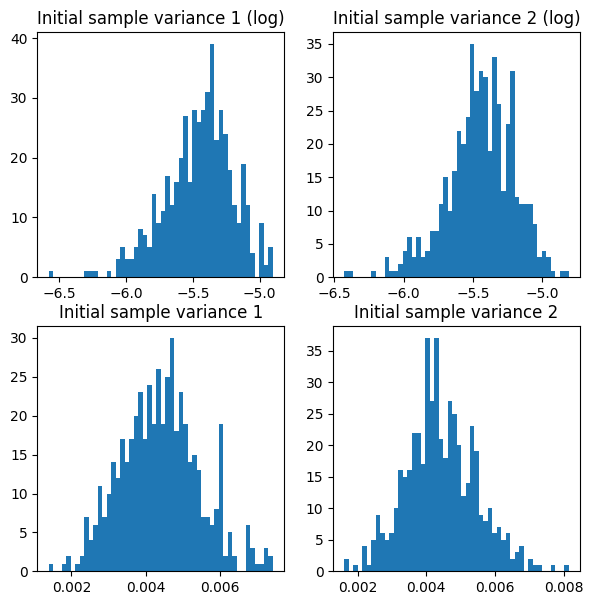

Mean Pretrain starts


  0%|          | 0/1 [00:00<?, ?it/s]

Terms : tensor([106.5219,  76.0878], device='cuda:0', grad_fn=<MeanBackward1>), tensor([0.0008, 0.0008], device='cuda:0', grad_fn=<DivBackward0>)
Pretrain h-lik loss (m-step) : 182.61126708984375
Terms : tensor([70.9470, 78.6005], device='cuda:0', grad_fn=<MeanBackward1>), tensor([0.0008, 0.0008], device='cuda:0', grad_fn=<DivBackward0>)
Pretrain h-lik loss (m-step) : 149.54905700683594
Terms : tensor([44.8267, 69.9712], device='cuda:0', grad_fn=<MeanBackward1>), tensor([0.0008, 0.0008], device='cuda:0', grad_fn=<DivBackward0>)
Pretrain h-lik loss (m-step) : 114.79948425292969
Terms : tensor([30.5281, 55.5711], device='cuda:0', grad_fn=<MeanBackward1>), tensor([0.0008, 0.0008], device='cuda:0', grad_fn=<DivBackward0>)
Pretrain h-lik loss (m-step) : 86.1007308959961
Terms : tensor([28.9922, 56.2840], device='cuda:0', grad_fn=<MeanBackward1>), tensor([0.0008, 0.0008], device='cuda:0', grad_fn=<DivBackward0>)
Pretrain h-lik loss (m-step) : 85.27781677246094
Terms : tensor([26.7882, 53.951

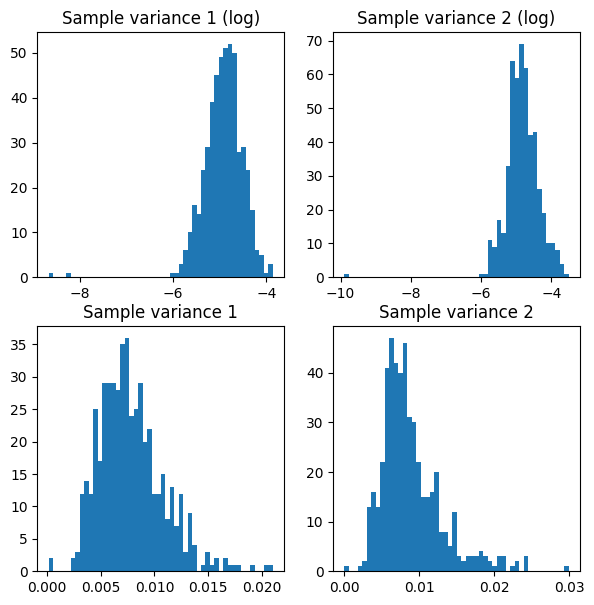

Mean Pretrain spends 255.6473 sec
Variance Pretrain starts


  0%|          | 0/20 [00:00<?, ?it/s]

0-th epoch last batch Pretrain h-lik loss (v-step) : 4.996906280517578
1-th epoch last batch Pretrain h-lik loss (v-step) : 4.826056003570557
2-th epoch last batch Pretrain h-lik loss (v-step) : 4.4338154792785645
3-th epoch last batch Pretrain h-lik loss (v-step) : 4.810028076171875
4-th epoch last batch Pretrain h-lik loss (v-step) : 4.776227951049805
5-th epoch last batch Pretrain h-lik loss (v-step) : 3.760399580001831
6-th epoch last batch Pretrain h-lik loss (v-step) : 4.702475070953369
7-th epoch last batch Pretrain h-lik loss (v-step) : 4.952794075012207
8-th epoch last batch Pretrain h-lik loss (v-step) : 4.574713230133057
9-th epoch last batch Pretrain h-lik loss (v-step) : 4.277250289916992
10-th epoch last batch Pretrain h-lik loss (v-step) : 5.122879505157471
11-th epoch last batch Pretrain h-lik loss (v-step) : 5.258169174194336
12-th epoch last batch Pretrain h-lik loss (v-step) : 4.690752983093262
13-th epoch last batch Pretrain h-lik loss (v-step) : 4.419584274291992
1

  0%|          | 0/150 [00:00<?, ?it/s]

Terms : tensor([3.5163, 4.2272], device='cuda:0', grad_fn=<MeanBackward1>), tensor([0.0052, 0.0052], device='cuda:0', grad_fn=<DivBackward0>)
Terms : tensor([270.6367, 520.2084], device='cuda:0', grad_fn=<MeanBackward1>), tensor([2.4956, 3.5052], device='cuda:0', grad_fn=<DivBackward0>)
Terms : tensor([86.9886, 85.2925], device='cuda:0', grad_fn=<MeanBackward1>), tensor([2.4624, 1.8771], device='cuda:0', grad_fn=<DivBackward0>)
Terms : tensor([72.4994, 70.3473], device='cuda:0', grad_fn=<MeanBackward1>), tensor([1.9999, 2.0927], device='cuda:0', grad_fn=<DivBackward0>)
Terms : tensor([62.6501, 60.3187], device='cuda:0', grad_fn=<MeanBackward1>), tensor([2.3863, 3.2790], device='cuda:0', grad_fn=<DivBackward0>)
Terms : tensor([63.3148, 85.9891], device='cuda:0', grad_fn=<MeanBackward1>), tensor([2.9685, 4.5339], device='cuda:0', grad_fn=<DivBackward0>)
Terms : tensor([67.4861, 78.6414], device='cuda:0', grad_fn=<MeanBackward1>), tensor([3.2235, 5.0259], device='cuda:0', grad_fn=<DivBack

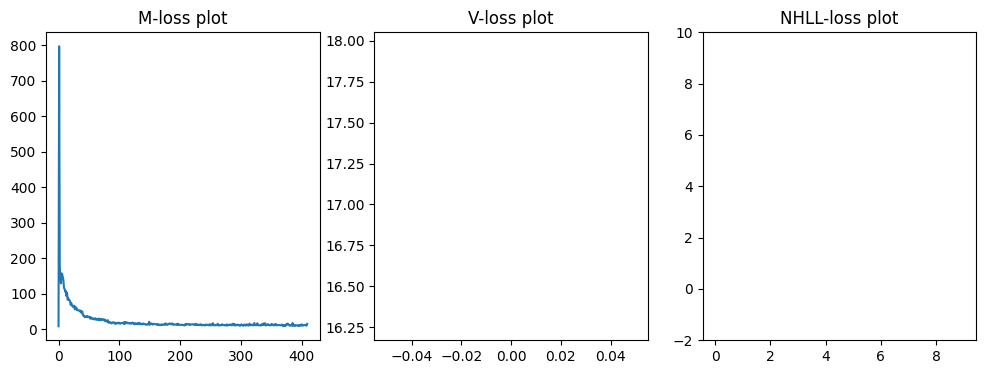

_LinAlgError: ignored

In [15]:
#@title Main algorihtm


for fold in [0] :

    train_ids = np.concatenate([ids[:fold], ids[(fold+1):]]).reshape(-1)
    train_images = torch.cat([images[:fold], images[(fold+1):]]).reshape(-1,36,60)
    train_hps = torch.cat([hps[:fold], hps[(fold+1):]]).reshape(-1,2)
    train_gazes = torch.cat([gazes[:fold], gazes[(fold+1):]]).reshape(-1,2)

    test_ids = ids[fold]
    test_images = images[fold]
    test_hps = hps[fold]
    test_gazes = gazes[fold]


    res_list.append(hetero_covariance_without_val(
        train_ids, train_images, train_hps, train_gazes,
        test_ids, test_images, test_hps, test_gazes,
        ResNet_batchnorm.ResNet_batchnorm, hidden_features=hidden_features, K=2, initialize_Sigma=initialize_Sigma,
        mean_lr=mean_lr, variance_lr=variance_lr, weight_decay=weight_decay, batch_size=batch_size,
        pretrain_iter=pretrain_iter, m_pretrain_epoch=m_pretrain_epoch, v_pretrain_epoch=v_pretrain_epoch, max_iter=max_iter, mean_epoch=mean_epoch, v_step_iter=v_step_iter, patience=patience,
        device=device, experiment_name=f'{experiment_name}_{fold}', SEED=seed + fold,
        normalize=True, deg=True, test_unseen=False, weighted=True, variance_check=True, verbose=True, bins=50, reset_opt=reset_opt))
